**Import Required Libraries:**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

**Device Configuration:**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


**Load & Preprocess Data:**

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 274kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.11MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]


**Training Data:**

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

In [5]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

**Test Data:**

In [8]:
df_test = pd.read_csv("/content/fashion-mnist_test.csv")

X_test = df_test.drop("label", axis=1).values.astype(np.float32)
y_test = df_test["label"].values

X_test = X_test / 255.0
X_test = (X_test - 0.5) / 0.5
X_test = X_test.reshape(-1, 1, 28, 28)

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).long()

test_dataset = TensorDataset(X_test, y_test)

**Data Loaders:**

In [9]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Multi-layer Feed Forward Neural Network:**

In [10]:
class FashionNet(nn.Module):
    def __init__(self, hidden_layers, activation="relu"):
        super().__init__()

        self.layers = nn.ModuleList()
        self.activations = {}

        input_size = 28 * 28

        for i, hidden_units in enumerate(hidden_layers):
            linear = nn.Linear(input_size, hidden_units)
            self.layers.append(linear)

            if activation == "relu":
                act = nn.ReLU()
            elif activation == "sigmoid":
                act = nn.Sigmoid()
            elif activation == "tanh":
                act = nn.Tanh()
            elif activation == "leaky_relu":
                act = nn.LeakyReLU(0.01)

            self.layers.append(act)

            # Hook for visualization
            linear.register_forward_hook(self.save_activation(f"Layer_{i+1}"))
            input_size = hidden_units

        self.output = nn.Linear(input_size, 10)

    def save_activation(self, name):
        def hook(model, input, output):
            self.activations[name] = output.detach()
        return hook

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return self.output(x)

**Training Function:**

In [11]:
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.to(device)
    history = {"loss": [], "accuracy": []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        history["loss"].append(epoch_loss)
        history["accuracy"].append(epoch_acc)

        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss:.4f}  Accuracy: {epoch_acc:.2f}%")

    return history

**Evaluation Function:**

In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

**Base Model Training:**

In [13]:
model = FashionNet(
    hidden_layers=[128, 128, 128],
    activation="relu"
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)

Epoch [1/10]  Loss: 0.5183  Accuracy: 81.14%
Epoch [2/10]  Loss: 0.3807  Accuracy: 86.13%
Epoch [3/10]  Loss: 0.3445  Accuracy: 87.26%
Epoch [4/10]  Loss: 0.3163  Accuracy: 88.28%
Epoch [5/10]  Loss: 0.2971  Accuracy: 89.03%
Epoch [6/10]  Loss: 0.2819  Accuracy: 89.62%
Epoch [7/10]  Loss: 0.2696  Accuracy: 89.95%
Epoch [8/10]  Loss: 0.2599  Accuracy: 90.29%
Epoch [9/10]  Loss: 0.2495  Accuracy: 90.47%
Epoch [10/10]  Loss: 0.2372  Accuracy: 91.02%
Test Accuracy: 90.32%


90.32

**Experimenting with different depth and widths:**

In [14]:
depths = [1, 3, 5]
widths = [64, 128]

for d in depths:
    for w in widths:
        print(f"\nDepth: {d}, Width: {w}")
        model = FashionNet([w] * d, activation="relu")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_model(model, train_loader, criterion, optimizer, epochs=5)
        evaluate_model(model, test_loader)


Depth: 1, Width: 64
Epoch [1/5]  Loss: 0.5224  Accuracy: 81.35%
Epoch [2/5]  Loss: 0.4008  Accuracy: 85.56%
Epoch [3/5]  Loss: 0.3632  Accuracy: 86.97%
Epoch [4/5]  Loss: 0.3408  Accuracy: 87.61%
Epoch [5/5]  Loss: 0.3184  Accuracy: 88.41%
Test Accuracy: 88.18%

Depth: 1, Width: 128
Epoch [1/5]  Loss: 0.5033  Accuracy: 81.75%
Epoch [2/5]  Loss: 0.3784  Accuracy: 86.22%
Epoch [3/5]  Loss: 0.3388  Accuracy: 87.52%
Epoch [4/5]  Loss: 0.3133  Accuracy: 88.42%
Epoch [5/5]  Loss: 0.2978  Accuracy: 88.97%
Test Accuracy: 89.33%

Depth: 3, Width: 64
Epoch [1/5]  Loss: 0.5575  Accuracy: 79.68%
Epoch [2/5]  Loss: 0.3962  Accuracy: 85.45%
Epoch [3/5]  Loss: 0.3554  Accuracy: 86.89%
Epoch [4/5]  Loss: 0.3334  Accuracy: 87.68%
Epoch [5/5]  Loss: 0.3123  Accuracy: 88.38%
Test Accuracy: 88.41%

Depth: 3, Width: 128
Epoch [1/5]  Loss: 0.5188  Accuracy: 80.98%
Epoch [2/5]  Loss: 0.3776  Accuracy: 86.03%
Epoch [3/5]  Loss: 0.3391  Accuracy: 87.47%
Epoch [4/5]  Loss: 0.3187  Accuracy: 88.17%
Epoch [5/5] 

**Different Activation Functions:**

In [15]:
activations = ["relu", "sigmoid", "tanh", "leaky_relu"]

for act in activations:
    print(f"\nActivation: {act}")
    start = time.time()

    model = FashionNet([128, 128, 128], activation=act)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, criterion, optimizer, epochs=5)
    evaluate_model(model, test_loader)

    print("Training Time:", round(time.time() - start, 2), "seconds")


Activation: relu
Epoch [1/5]  Loss: 0.5175  Accuracy: 81.09%
Epoch [2/5]  Loss: 0.3740  Accuracy: 86.22%
Epoch [3/5]  Loss: 0.3403  Accuracy: 87.40%
Epoch [4/5]  Loss: 0.3141  Accuracy: 88.39%
Epoch [5/5]  Loss: 0.2974  Accuracy: 88.97%
Test Accuracy: 88.56%
Training Time: 82.07 seconds

Activation: sigmoid
Epoch [1/5]  Loss: 0.8696  Accuracy: 67.67%
Epoch [2/5]  Loss: 0.4681  Accuracy: 83.75%
Epoch [3/5]  Loss: 0.3952  Accuracy: 85.94%
Epoch [4/5]  Loss: 0.3557  Accuracy: 87.40%
Epoch [5/5]  Loss: 0.3332  Accuracy: 88.07%
Test Accuracy: 88.08%
Training Time: 80.44 seconds

Activation: tanh
Epoch [1/5]  Loss: 0.5123  Accuracy: 81.56%
Epoch [2/5]  Loss: 0.3882  Accuracy: 85.81%
Epoch [3/5]  Loss: 0.3548  Accuracy: 87.05%
Epoch [4/5]  Loss: 0.3364  Accuracy: 87.60%
Epoch [5/5]  Loss: 0.3199  Accuracy: 88.28%
Test Accuracy: 88.30%
Training Time: 82.43 seconds

Activation: leaky_relu
Epoch [1/5]  Loss: 0.5222  Accuracy: 80.65%
Epoch [2/5]  Loss: 0.3822  Accuracy: 86.01%
Epoch [3/5]  Loss:

**Visualization of hidden layers:**

In [16]:
def visualize_activations(model, image):
    model.eval()
    with torch.no_grad():
        _ = model(image.to(device))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, len(model.activations) + 1, 1)
    plt.imshow(image[0].cpu().squeeze(), cmap="gray")
    plt.title("Input")
    plt.axis("off")

    for i, (name, act) in enumerate(model.activations.items()):
        plt.subplot(1, len(model.activations) + 1, i + 2)
        plt.plot(act[0].cpu().numpy()[:100])
        plt.title(name)
        plt.axis("off")

    plt.show()

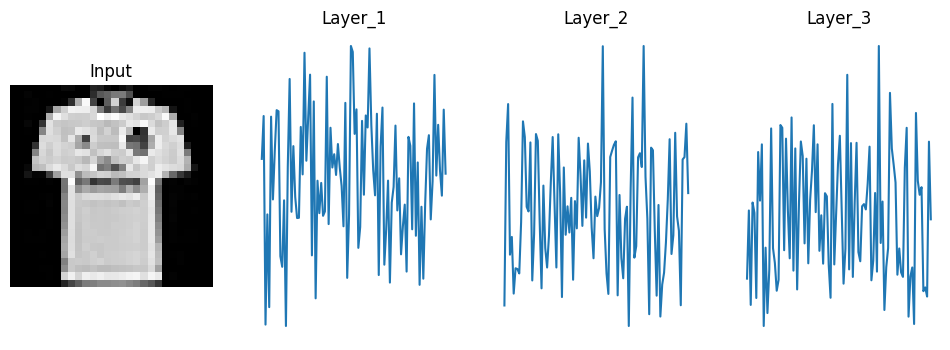

In [17]:
sample_image, _ = next(iter(test_loader))
visualize_activations(model, sample_image[:1])